# Libraries

In [1]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 22.2 MB/s eta 0:00:00


In [2]:
!pip install geopandas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations, permutations, product
import time
from tqdm import tqdm
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from pprint import pprint

In [4]:
WLSACCESSID = ''
WLSSECRET = ''
LICENSEID = 0

In [5]:
params = {
"WLSACCESSID": WLSACCESSID,
"WLSSECRET": WLSSECRET,
"LICENSEID": LICENSEID,
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 939556
Academic license 939556 - for non-commercial use only - registered to lu___@ieseg.fr


# Class implementations

## Master Problem

In [84]:
class MasterProblem:

  def __init__(self,IS_DF,nodes,edges,env):

    self.independentSetCost = IS_DF['independentSetCost'].values
    self.independentSet = IS_DF['independentSet'].values
    self.nodes = nodes
    self.edges = edges
    self.n_Nodes = len(nodes)
    self.model = gp.Model("MasterProblem",env=env)
    self.independentSetIndex = IS_DF.index.values

  def build_model(self):
    self.GenerateVariables()
    self.GenerateConstraints()
    self.GenerateObjective()
    self.model.update()

  def GenerateVariables(self):
    self.independentSetUseVar = self.model.addVars(self.independentSetIndex,
                                            vtype = GRB.BINARY,name = "independentSetUseVar")
  def GenerateConstraints(self):
    for i in range(self.n_Nodes):
      self.model.addConstr(gp.quicksum(self.independentSetUseVar[p]*self.independentSet[p][i] for p in self.independentSetIndex) >= 1, f'C_{i}')

  def GenerateObjective(self):
    self.model.setObjective(gp.quicksum(self.independentSetUseVar[p] for p in self.independentSetIndex),sense = GRB.MINIMIZE)

  def solveRelaxModel(self,silence=True):

    self.relaxedModel = self.model.relax()
    if silence:
      self.relaxedModel.setParam('LogToConsole',0)
    self.relaxedModel.optimize()

  def getDuals(self):

    return self.relaxedModel.getAttr("Pi",self.relaxedModel.getConstrs())

  def addColumn(self,objective,new_IS):

    ctName = f'independentSetUseVar[{len(self.model.getVars())}]'
    new_column = gp.Column(new_IS,self.model.getConstrs())
    self.model.addVar(vtype = GRB.INTEGER,lb = 0, obj = objective, column = new_column,name = ctName)
    self.model.update()

  def solveFinalModel(self,time_limit = 3600,mipgap = 0.05,silence = True):

    self.model.setParam('TimeLimit',time_limit)
    self.model.setParam('MIPGap',mipgap)
    if silence:
       self.model.setParam('LogToConsole',0)

    self.model.optimize()

  def extractSolution(self,silence = True):

    all_vars = self.model.getVars()
    values = self.model.getAttr("X", all_vars)
    names = self.model.getAttr("VarName", all_vars)

    solution = list()

    if not silence:
      print(f"Total number of colors needed = {self.model.getObjective().getValue()}")

    for name,x,pattern in zip(names,values,NEW_independent_sets):
      if x >= 0.99:
        indices = [index for index, value in enumerate(pattern) if value == 1.0]
        solution.append(indices)
    output = list()
    for c,i_S in enumerate(solution):
      for x in i_S:
        output.append((x,c))
        if not silence:
          print(f"job-{x+1} assigned to color {c+1}")

    return output




## SubProblem

In [79]:
class SubProblem:

  def __init__(self,IS_DF,nodes,edges,env,duals):

    self.independentSetCost = IS_DF['independentSetCost'].values
    self.independentSet = IS_DF['independentSet'].values
    self.nodes = nodes
    self.edges = edges
    self.n_Nodes = len(nodes)
    self.duals = duals
    self.model = gp.Model("SubProblem",env=env)
    self.nodesIndex = IS_DF.index.values


  def buildModel(self):
    self.GenerateVariables()
    self.GenerateConstraints()
    self.GenerateObjective()
    self.model.update()

  def GenerateVariables(self):
    self.nodePatternVar = self.model.addVars(self.nodesIndex,
                                                 vtype = GRB.BINARY,name = "nodePatternVar")
  def GenerateConstraints(self):

    for u,v in self.edges:

      self.model.addConstr(self.nodePatternVar[u] + self.nodePatternVar[v] <= 1)

  def GenerateObjective(self):
    self.model.setObjective(gp.quicksum(self.nodePatternVar[p]*self.duals[p] for p in self.nodesIndex),sense = GRB.MAXIMIZE)

  def getNewPattern(self):
    return self.model.getAttr("X",self.model.getVars())

  def solveModel(self,time_limit = 3600,mipgap = 0.05,silence = True):

    self.model.setParam('TimeLimit',time_limit)
    self.model.setParam('MIPGap',mipgap)
    if silence:
       self.model.setParam('LogToConsole',0)
    self.model.optimize()

  def getObjectiveValue(self):
    return self.model.getObjective().getValue()

In [61]:
class InitialPatternGenerator:

  def __init__(self,Graph):
    columns = ['independentSetCost','independentSet']
    self.G = Graph
    self.nodes = list(self.G.nodes())
    self.edges = list(self.G.edges())
    self.n_Nodes = len(self.nodes)
    IndepndentSet = pd.DataFrame(index = range(self.n_Nodes),columns = columns)
    self.IS_DF = IndepndentSet

  def generateBasicSingletons(self):

    self.IS_DF['independentSetCost'] = 1
    self.IS_DF['independentSet'] = [np.where(self.IS_DF.index == j,1,0) for j in range(self.n_Nodes)]
    return self.IS_DF

  def generate_dictionaries(self):

    name_to_number = dict()
    number_to_name = dict()

    for i,v in enumerate(self.nodes):
      name_to_number[v] = i
      number_to_name[i] = v

    self.name_to_number_dict = name_to_number
    self.number_to_name_dict = number_to_name

  def get_numeric_v_and_e(self):

    edges = []

    for u,v in self.edges:

      u = self.name_to_number_dict[u]
      v = self.name_to_number_dict[v]

      edges.append((u,v))

    nodes = [self.name_to_number_dict[x] for x in self.nodes]

    return nodes, edges

# Problem data

In [49]:
data = {
    'Job': ['Job-1', 'Job-2', 'Job-3', 'Job-4', 'Job-5', 'Job-6', 'Job-7', 'Job-8', 'Job-9', 'Job-10'],
    'Start': ['2024-06-01', '2024-06-05', '2024-06-08', '2024-06-10', '2024-06-15', '2024-06-18', '2024-06-20', '2024-06-25', '2024-06-28', '2024-07-01'],
    'End': ['2024-06-10', '2024-06-12', '2024-06-15', '2024-06-20', '2024-06-25', '2024-06-28', '2024-07-05', '2024-07-08', '2024-07-10', '2024-07-15']
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert Start and End to datetime
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

In [50]:
# Create the graph
G = nx.Graph()

# Add nodes
for job in df['Job']:
    G.add_node(job)

# Add edges based on overlapping dates or start date being less than 3 days after the end date of another job
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        job1, job2 = df.iloc[i], df.iloc[j]
        if (job1['Start'] <= job2['End'] and job2['Start'] <= job1['End']) or \
           (abs((job1['End'] - job2['Start']).days) < 3 or abs((job2['End'] - job1['Start']).days) < 3):
            G.add_edge(job1['Job'], job2['Job'])



In [51]:
# Print the edges of the graph to check
print("Edges of the graph:")
pprint(list(G.edges()),width=60,compact=True)

Edges of the graph:
[('Job-1', 'Job-2'), ('Job-1', 'Job-3'), ('Job-1', 'Job-4'),
 ('Job-2', 'Job-3'), ('Job-2', 'Job-4'), ('Job-3', 'Job-4'),
 ('Job-3', 'Job-5'), ('Job-4', 'Job-5'), ('Job-4', 'Job-6'),
 ('Job-4', 'Job-7'), ('Job-5', 'Job-6'), ('Job-5', 'Job-7'),
 ('Job-5', 'Job-8'), ('Job-6', 'Job-7'), ('Job-6', 'Job-8'),
 ('Job-6', 'Job-9'), ('Job-7', 'Job-8'), ('Job-7', 'Job-9'),
 ('Job-7', 'Job-10'), ('Job-8', 'Job-9'),
 ('Job-8', 'Job-10'), ('Job-9', 'Job-10')]


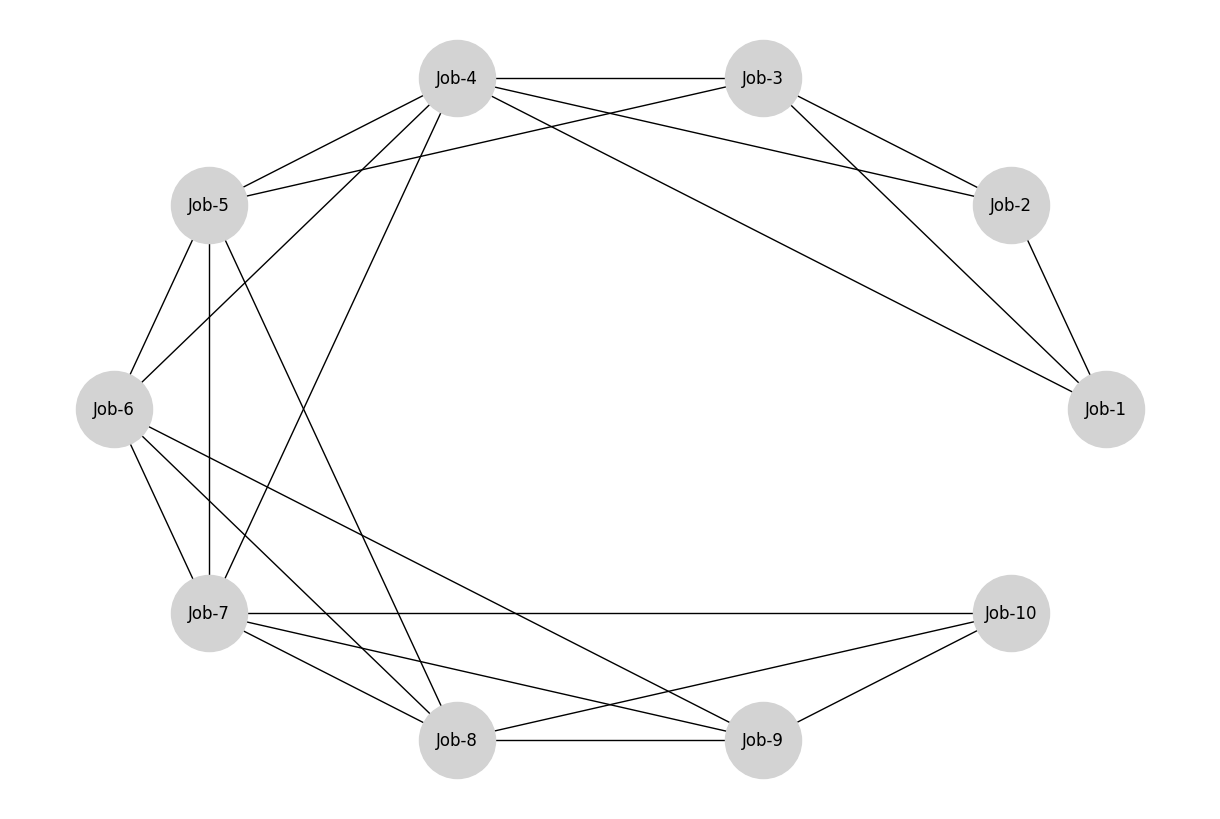

In [52]:
plt.figure(figsize=(12, 8))
pos = nx.circular_layout(G)
nx.draw(G,pos= pos, with_labels=True, node_size=3000, font_size=12,node_color='lightgrey')
plt.show()

# Simple binary formulation

In [27]:
E = list(G.edges())
V = list(G.nodes())

In [28]:
H,V = range(len(V)), range(len(V))

In [29]:
x_var = [(v,i) for v in V for i in H ]

In [30]:
model = gp.Model("Binary_ILP",env=env)

W = model.addVars(H,vtype=GRB.BINARY, name="w")
X = model.addVars(x_var ,vtype=GRB.BINARY, name="x")

model.setObjective(gp.quicksum(W[i] for i in H),GRB.MINIMIZE);

for v in V:
  model.addConstr(gp.quicksum(X[(v,i)] for i in H) == 1 )

for i in H:
  for u,v in E:

    u = int(u.split("-")[1])-1
    v = int(v.split("-")[1])-1

    model.addConstr(X[(v,i)] + X[(u,i)] <= W[i] )

for i in H:
  model.addConstr(gp.quicksum(X[(v,i)] for v in V) >= W[i])

for i in range(1,len(V)):
  model.addConstr(W[i] <= W[i-1])


In [31]:
timelimit = 600
mipgap = 0.0

model.setParam('TimeLimit', timelimit)
model.setParam('MIPGap',mipgap)
model.optimize()

Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 939556 - for non-commercial use only - registered to lu___@ieseg.fr
Optimize a model with 249 rows, 110 columns and 888 nonzeros
Model fingerprint: 0x143aca6e
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 7.0000000
Presolve removed 187 rows and 35 columns
Presolve time: 0.01s
Presolved: 62 rows, 75 columns, 333 nonzeros
Variable types: 0 continuous, 75 integer (75 binary)

Root relaxation: objective 4.000000e+00, 54 iterations, 0.00 seconds (0.00 work units)

    Nodes 

In [46]:
colors = ['lightskyblue','tomato','lime','lemonchiffon']

In [47]:
print(f"Total number of colors needed = {model.getObjective().getValue()}")
node_colors = []
for key in X.keys():

  if X[key].x >= 0.99:

    print(f" job-{key[0] +1} is colored with color: {colors[key[1]]}")
    node_colors.append(colors[key[1]])

Total number of colors needed = 4.0
 job-1 is colored with color: tomato
 job-2 is colored with color: lemonchiffon
 job-3 is colored with color: lime
 job-4 is colored with color: lightskyblue
 job-5 is colored with color: lemonchiffon
 job-6 is colored with color: lime
 job-7 is colored with color: tomato
 job-8 is colored with color: lightskyblue
 job-9 is colored with color: lemonchiffon
 job-10 is colored with color: lime


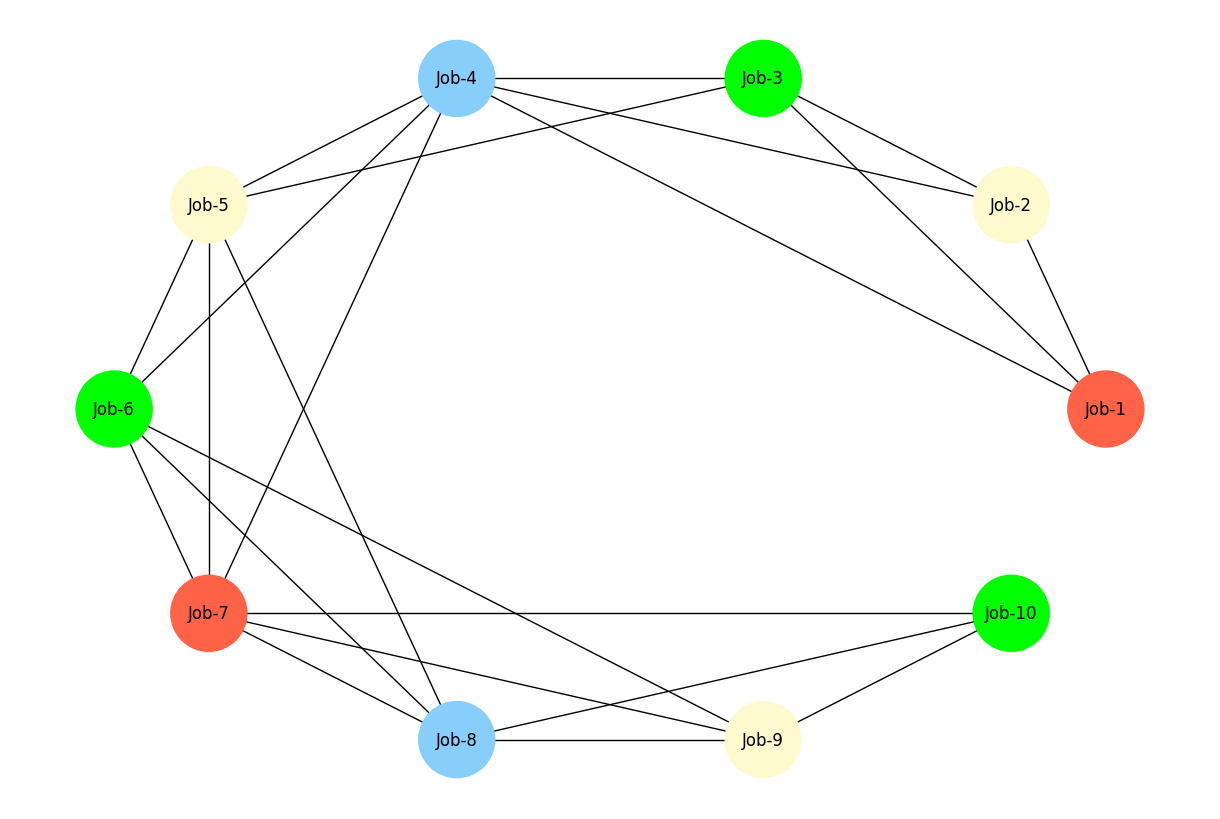

In [45]:
plt.figure(figsize=(12, 8))
pos = nx.circular_layout(G)
nx.draw(G,pos= pos, with_labels=True, node_size=3000, font_size=12,node_color=node_colors)
plt.show()

# Column generation

In [53]:
IS_generator = InitialPatternGenerator(G)

In [54]:
IS_generator.generate_dictionaries()

In [58]:
nodes,edges = IS_generator.get_numeric_v_and_e()

In [59]:
IS_DF = IS_generator.generateBasicSingletons()
IS_DF

,independentSetCost,independentSet
0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
4,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
5,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
6,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
7,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
8,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
9,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


# Main loop

In [85]:
master = MasterProblem(IS_DF,nodes,edges,env)
master.build_model()

NEW_independent_sets = [x.tolist() for x in IS_DF['independentSet'].values]

modelImprovable = True
counter = 0

for i in range(20):

  print(f"Iteration: {counter}")

  master.solveRelaxModel()
  duals = master.getDuals()

  subproblem = SubProblem(IS_DF,nodes,edges,env,duals)
  subproblem.buildModel()

  subproblem.solveModel(120,0.0,True)

  modelImprovable = 1 - subproblem.getObjectiveValue() < 0

  print("gain",1 - subproblem.getObjectiveValue())

  if modelImprovable:

    new_independent_set_cost = 1

    new_independent_set = subproblem.getNewPattern()
    print(new_independent_set)

    NEW_independent_sets.append(new_independent_set)

    master.addColumn(new_independent_set_cost,new_independent_set)

    counter+=1
    print("-"*120)
  else:
    break

Iteration: 0
Set parameter TimeLimit to value 120
Set parameter MIPGap to value 0
gain -2.0
[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
------------------------------------------------------------------------------------------------------------------------
Iteration: 1
Set parameter TimeLimit to value 120
Set parameter MIPGap to value 0
gain -1.0
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
------------------------------------------------------------------------------------------------------------------------
Iteration: 2
Set parameter TimeLimit to value 120
Set parameter MIPGap to value 0
gain -1.0
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
------------------------------------------------------------------------------------------------------------------------
Iteration: 3
Set parameter TimeLimit to value 120
Set parameter MIPGap to value 0
gain -1.0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
-----------------------------------------------------------------

In [86]:
master.solveFinalModel(3600,0.00)

Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0


In [91]:
problem_solution = master.extractSolution(False)

Total number of colors needed = 4.0
job-3 assigned to color 1
job-7 assigned to color 1
job-4 assigned to color 2
job-8 assigned to color 2
job-2 assigned to color 3
job-6 assigned to color 3
job-10 assigned to color 3
job-1 assigned to color 4
job-5 assigned to color 4
job-9 assigned to color 4


In [93]:
colors = ['lightskyblue','tomato','lime','lemonchiffon']
node_colors = [None for x in range(len(nodes))]
for x,c in problem_solution:
  node_colors[x] = colors[c]

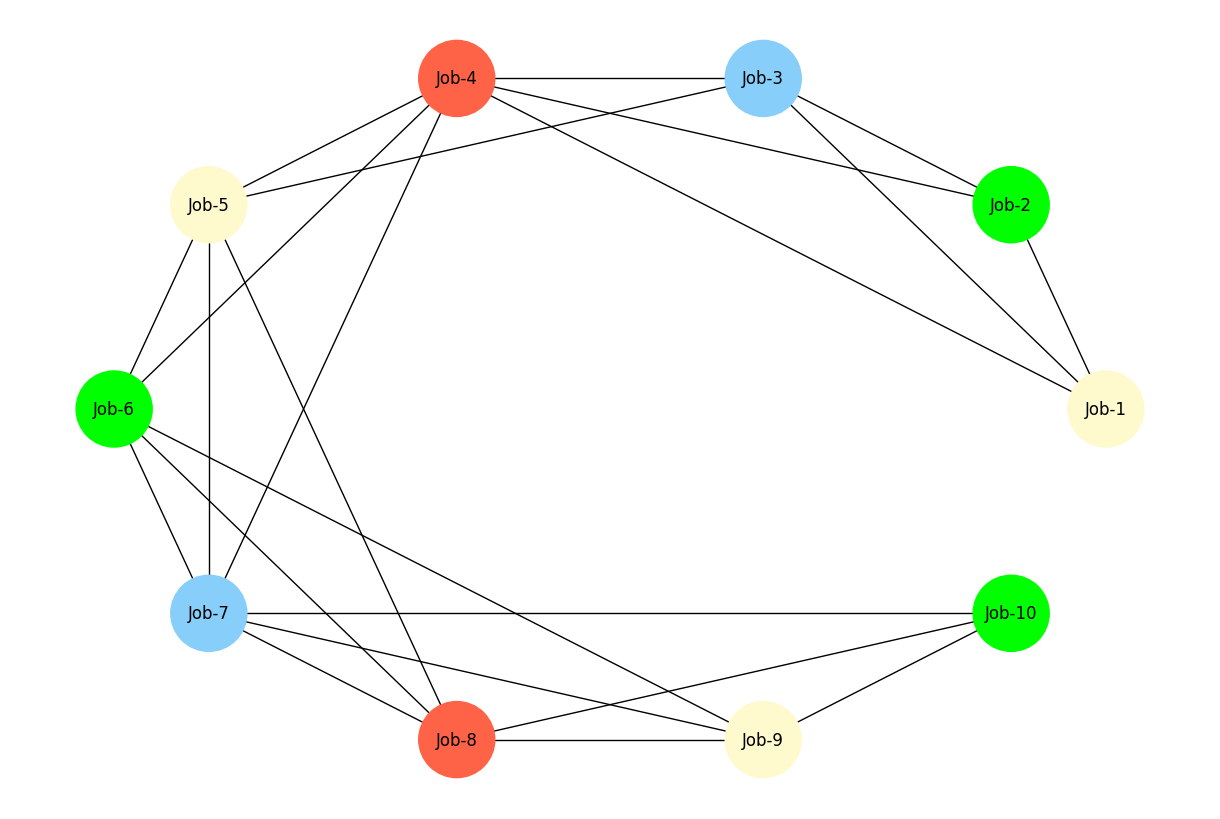

In [95]:
plt.figure(figsize=(12, 8))
pos = nx.circular_layout(G)
nx.draw(G,pos= pos, with_labels=True, node_size=3000, font_size=12,node_color=node_colors)
plt.show()

In [69]:
all_vars = master.model.getVars()
values = master.model.getAttr("X", all_vars)
names = master.model.getAttr("VarName", all_vars)

In [72]:
print(f"Total number of colors needed = {master.model.getObjective().getValue()}")
for name,x,pattern in zip(names,values,NEW_independent_sets):
  if x >= 0.99:
    print(f"Name: {name},pattern: {pattern}, taken: {bool(x)}")

Total number of colors needed = 4.0
Name: independentSetUseVar[20],pattern: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], taken: True
Name: independentSetUseVar[21],pattern: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], taken: True
Name: independentSetUseVar[25],pattern: [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], taken: True
Name: independentSetUseVar[27],pattern: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0], taken: True
